In [1]:
!pip install torch torch_geometric rdkit giotto-tda egnn-pytorch

Extracting data/QM9/raw/qm9.zip
Processing...
100%|██████████| 133885/133885 [02:27<00:00, 905.78it/s] 
Done!


Количество молекул: 130831
Структура одной молекулы (Data object):
Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], smiles='[H]C([H])([H])[H]', name='gdb_1', idx=[1])


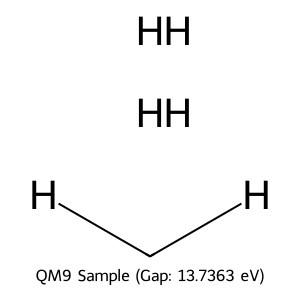

In [3]:
import torch
from torch_geometric.datasets import QM9
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from IPython.display import display

dataset = QM9(root='data/QM9')

print(f"Количество молекул: {len(dataset)}")
sample_mol = dataset[0]

print("Структура одной молекулы (Data object):")
print(sample_mol)
# x: признаки узлов (атомный номер, заряды и т.д.)
# pos: 3D координаты атомов
# edge_index: индекс связей
# y: таргеты (19 штук)

# Визуализация в 2D (через RDKit)
def visualize_molecule(data):
    # Конвертируем атомные номера (z) в символы
    atomic_map = {1: 'H', 6: 'C', 7: 'N', 8: 'O', 9: 'F'}
    symbols = [atomic_map[z.item()] for z in data.z]

    # Создаем пустую молекулу
    mol = Chem.RWMol()
    node_to_idx = {}

    for i, symbol in enumerate(symbols):
        idx = mol.AddAtom(Chem.Atom(symbol))
        node_to_idx[i] = idx

    # Добавляем связи из edge_index
    edges = data.edge_index.t().numpy()
    for i in range(0, len(edges), 2): # связи дублируются (туда-обратно)
        u, v = edges[i]
        if u < v:
            mol.AddBond(int(u), int(v), Chem.BondType.SINGLE)

    return mol

mol = visualize_molecule(sample_mol)
img = Draw.MolToImage(mol, size=(300, 300), legend=f"QM9 Sample (Gap: {sample_mol.y[0, 4]:.4f} eV)")
display(img)

In [13]:
import torch
import torch.nn as nn
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_add_pool
from egnn_pytorch import EGNN
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceImage
from gtda.diagrams import BettiCurve
import numpy as np
import time

TARGET_IDX = 4  # Gap
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-3
NUM_SAMPLES = 20000

NUM_TRAIN = int(NUM_SAMPLES * 0.8)
NUM_TEST = NUM_SAMPLES - NUM_TRAIN

train_y_raw = torch.tensor([dataset[i].y[0, TARGET_IDX] for i in range(NUM_TRAIN)])

Y_MEAN = train_y_raw.mean().item()
Y_STD = train_y_raw.std().item()

In [23]:
# ПРЕДРАСЧЕТ TDA ФИЧ
# Считаем заранее, чтобы не тормозить обучение
def precompute_tda(dataset):
    VR = VietorisRipsPersistence(homology_dimensions=[0, 1], n_jobs=-1)
    PI = PersistenceImage(n_bins=10, sigma=0.1)
    BC = BettiCurve(n_bins=100)

    tda_list = []
    for data in dataset[:NUM_SAMPLES]:
        pos = data.pos.numpy()
        diagrams = VR.fit_transform([pos])
        images = PI.fit_transform(diagrams)
        curves = BC.fit_transform(diagrams)
        tda_list.append(np.concatenate([images.flatten(), curves.flatten()]))
    return torch.tensor(np.array(tda_list), dtype=torch.float32)

tda_data = precompute_tda(dataset)

# Модифицированный даталоадер, который отдает еще и TDA
class TDA_QM9_Wrapper:
    def __init__(self, ds, tda_feats, start_idx, end_idx):
        self.ds = ds[start_idx:end_idx]
        self.tda = tda_feats[start_idx:end_idx]
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, idx):
        data = self.ds[idx]
        return data, self.tda[idx]

# кастомный collate для даталоадера
def tda_collate(batch):
    data_list, tda_list = zip(*batch)
    from torch_geometric.data import Batch
    return Batch.from_data_list(data_list), torch.stack(tda_list)

train_loader = DataLoader(TDA_QM9_Wrapper(dataset, tda_data, 0, NUM_TRAIN),
                          batch_size=BATCH_SIZE, shuffle=True, collate_fn=tda_collate)

test_loader = DataLoader(TDA_QM9_Wrapper(dataset, tda_data, NUM_TRAIN, NUM_TRAIN + NUM_TEST),
                         batch_size=BATCH_SIZE, shuffle=False, collate_fn=tda_collate)

/usr/local/lib/python3.12/dist-packages/gtda/homology/simplicial.py:232: DataDimensionalityWarning: All arrays/matrices are square. This is consistent with a collection of distance/adjacency matrices, but the entries will be treated as collections of vectors in Euclidean space.
  check_point_clouds(X, accept_sparse=True,
/usr/local/lib/python3.12/dist-packages/gtda/homology/simplicial.py:299: DataDimensionalityWarning: All arrays/matrices are square. This is consistent with a collection of distance/adjacency matrices, but the entries will be treated as collections of vectors in Euclidean space.
  X = check_point_clouds(X, accept_sparse=True,
/usr/local/lib/python3.12/dist-packages/gtda/homology/simplicial.py:232: DataDimensionalityWarning: All arrays/matrices are square. This is consistent with a collection of distance/adjacency matrices, but the entries will be treated as collections of vectors in Euclidean space.
  check_point_clouds(X, accept_sparse=True,
/usr/local/lib/python3.12/d

In [24]:
from torch_geometric.utils import to_dense_batch

class EGNNRegressor(nn.Module):
    def __init__(self, node_dim=11, hidden_dim=128, tda_dim=400, use_tda=True):
        super().__init__()
        self.use_tda = use_tda

        # Эмбеддинг типов атомов
        self.embedding = nn.Linear(node_dim, hidden_dim)

        # Стеки EGNN (обработка 3D геометрии)
        self.egnn1 = EGNN(dim=hidden_dim, m_dim=hidden_dim)
        self.egnn2 = EGNN(dim=hidden_dim, m_dim=hidden_dim)

        # Регрессор
        reg_input_dim = hidden_dim + (tda_dim if use_tda else 0)
        self.regressor = nn.Sequential(
            nn.Linear(reg_input_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x, pos, batch_idx, tda_feats=None):
        h = self.embedding(x)

        # Перевод в плотный батч [Batch, Max_Nodes, Dim] для egnn-pytorch
        h_dense, mask = to_dense_batch(h, batch_idx)
        pos_dense, _ = to_dense_batch(pos, batch_idx)

        # Проход через эквивариантные слои с маской
        h_dense, pos_dense = self.egnn1(h_dense, pos_dense, mask=mask)
        h_dense, pos_dense = self.egnn2(h_dense, pos_dense, mask=mask)

        # Masked Mean Pooling (Агрегация узлов в вектор молекулы)
        # Зануляем padding-узлы перед суммированием
        h_masked = h_dense * mask.unsqueeze(-1)
        # Делим на реальное количество атомов в каждой молекуле
        num_atoms = mask.sum(dim=1, keepdim=True)
        h_graph = h_masked.sum(dim=1) / (num_atoms + 1e-8)

        # Присоединение TDA (если включено)
        if self.use_tda and tda_feats is not None:
            combined = torch.cat([h_graph, tda_feats], dim=-1)
        else:
            combined = h_graph

        return self.regressor(combined)

In [30]:
def train_model(model, epochs, loader, name):
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.L1Loss() # MAE лосс
    model.to(DEVICE)

    print(f"Начало обучения модели: {name}")

    for epoch in range(epochs):
        model.train()
        total_loss = 0      # Лосс на нормализованных данных
        total_mae_ev = 0    # Реальная ошибка в эВ

        for batch_data, batch_tda in loader:
            batch_data = batch_data.to(DEVICE)
            batch_tda = batch_tda.to(DEVICE)

            optimizer.zero_grad()

            # ПРЕДСКАЗАНИЕ
            if model.use_tda:
                pred_norm = model(batch_data.x, batch_data.pos, batch_data.batch, batch_tda)
            else:
                pred_norm = model(batch_data.x, batch_data.pos, batch_data.batch, tda_feats=None)

            target_ev = batch_data.y[:, TARGET_IDX].view(-1, 1)
            # Нормализуем таргет (Z-score): (y - mean) / std
            target_norm = (target_ev - Y_MEAN) / Y_STD

            # Считаем лосс на нормализованных числах (они в районе нуля, это стабильно)
            loss = criterion(pred_norm, target_norm)

            loss.backward()
            # Ограничение градиентов, чтобы веса не взрывались
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # СБОР МЕТРИК
            with torch.no_grad():
                # Переводим предсказание обратно в эВ для логов: (pred * std) + mean
                pred_ev = pred_norm * Y_STD + Y_MEAN
                mae_ev = torch.abs(pred_ev - target_ev).mean()

                total_loss += loss.item()
                total_mae_ev += mae_ev.item()

        # Логирование каждую эпоху
        avg_loss = total_loss / len(loader)
        avg_mae = total_mae_ev / len(loader)
        print(f"Epoch {epoch+1:02d} | Loss (norm): {avg_loss:.4f} | MAE: {avg_mae:.4f} eV")

    return avg_mae

In [26]:
def evaluate_model(model, loader):
    model.eval()
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for batch_data, batch_tda in loader:
            batch_data = batch_data.to(DEVICE)
            batch_tda = batch_tda.to(DEVICE)

            if model.use_tda:
                pred_norm = model(batch_data.x, batch_data.pos, batch_data.batch, batch_tda)
            else:
                pred_norm = model(batch_data.x, batch_data.pos, batch_data.batch, tda_feats=None)

            # Денормализация
            pred_ev = pred_norm * Y_STD + Y_MEAN
            true_ev = batch_data.y[:, TARGET_IDX].view(-1, 1)

            all_predictions.append(pred_ev.cpu())
            all_true_labels.append(true_ev.cpu())

    return torch.cat(all_predictions), torch.cat(all_true_labels)


In [19]:
# Модель 1: Чистая EGNN
baseline_model = EGNNRegressor(use_tda=False)
baseline_mae = train_model(baseline_model, EPOCHS, train_loader, "Baseline EGNN")
baseline_predictions, baseline_true_labels = evaluate_model(baseline_model, test_loader)

Начало обучения модели: Baseline EGNN
Epoch 01 | Loss (norm): 0.6640 | MAE: 0.8598 eV
Epoch 02 | Loss (norm): 0.6171 | MAE: 0.7991 eV
Epoch 03 | Loss (norm): 0.5588 | MAE: 0.7237 eV
Epoch 04 | Loss (norm): 0.5300 | MAE: 0.6864 eV
Epoch 05 | Loss (norm): 0.5048 | MAE: 0.6537 eV
Epoch 06 | Loss (norm): 0.4542 | MAE: 0.5882 eV
Epoch 07 | Loss (norm): 0.4212 | MAE: 0.5455 eV
Epoch 08 | Loss (norm): 0.3729 | MAE: 0.4829 eV
Epoch 09 | Loss (norm): 0.3241 | MAE: 0.4197 eV
Epoch 10 | Loss (norm): 0.2831 | MAE: 0.3665 eV
Epoch 11 | Loss (norm): 0.2574 | MAE: 0.3334 eV
Epoch 12 | Loss (norm): 0.2312 | MAE: 0.2994 eV
Epoch 13 | Loss (norm): 0.2152 | MAE: 0.2787 eV
Epoch 14 | Loss (norm): 0.2010 | MAE: 0.2603 eV
Epoch 15 | Loss (norm): 0.1942 | MAE: 0.2514 eV
Epoch 16 | Loss (norm): 0.1851 | MAE: 0.2397 eV
Epoch 17 | Loss (norm): 0.1819 | MAE: 0.2356 eV
Epoch 18 | Loss (norm): 0.1697 | MAE: 0.2198 eV
Epoch 19 | Loss (norm): 0.1666 | MAE: 0.2157 eV
Epoch 20 | Loss (norm): 0.1649 | MAE: 0.2136 eV


In [31]:
# Модель 2: EGNN + TDA
tda_model = EGNNRegressor(use_tda=True, tda_dim=400) # 400 = 10x10 bins * 2 dims (H0, H1) + 100 bins * 2 dims (H0, H1)
tda_mae = train_model(tda_model, int(1.5*EPOCHS), train_loader, "EGNN + TDA Features")
tda_predictions, tda_true_labels = evaluate_model(tda_model, test_loader)

Начало обучения модели: EGNN + TDA Features
Epoch 01 | Loss (norm): 0.6831 | MAE: 0.8846 eV
Epoch 02 | Loss (norm): 0.6125 | MAE: 0.7932 eV
Epoch 03 | Loss (norm): 0.5671 | MAE: 0.7344 eV
Epoch 04 | Loss (norm): 0.5175 | MAE: 0.6702 eV
Epoch 05 | Loss (norm): 0.4745 | MAE: 0.6145 eV
Epoch 06 | Loss (norm): 0.4337 | MAE: 0.5616 eV
Epoch 07 | Loss (norm): 0.3991 | MAE: 0.5169 eV
Epoch 08 | Loss (norm): 0.3717 | MAE: 0.4813 eV
Epoch 09 | Loss (norm): 0.4276 | MAE: 0.5537 eV
Epoch 10 | Loss (norm): 0.3257 | MAE: 0.4218 eV
Epoch 11 | Loss (norm): 0.3132 | MAE: 0.4055 eV
Epoch 12 | Loss (norm): 0.3400 | MAE: 0.4402 eV
Epoch 13 | Loss (norm): 0.3038 | MAE: 0.3934 eV
Epoch 14 | Loss (norm): 0.2902 | MAE: 0.3758 eV
Epoch 15 | Loss (norm): 0.2874 | MAE: 0.3721 eV
Epoch 16 | Loss (norm): 0.2718 | MAE: 0.3520 eV
Epoch 17 | Loss (norm): 0.2662 | MAE: 0.3447 eV
Epoch 18 | Loss (norm): 0.2631 | MAE: 0.3407 eV
Epoch 19 | Loss (norm): 0.2575 | MAE: 0.3334 eV
Epoch 20 | Loss (norm): 0.2516 | MAE: 0.3258

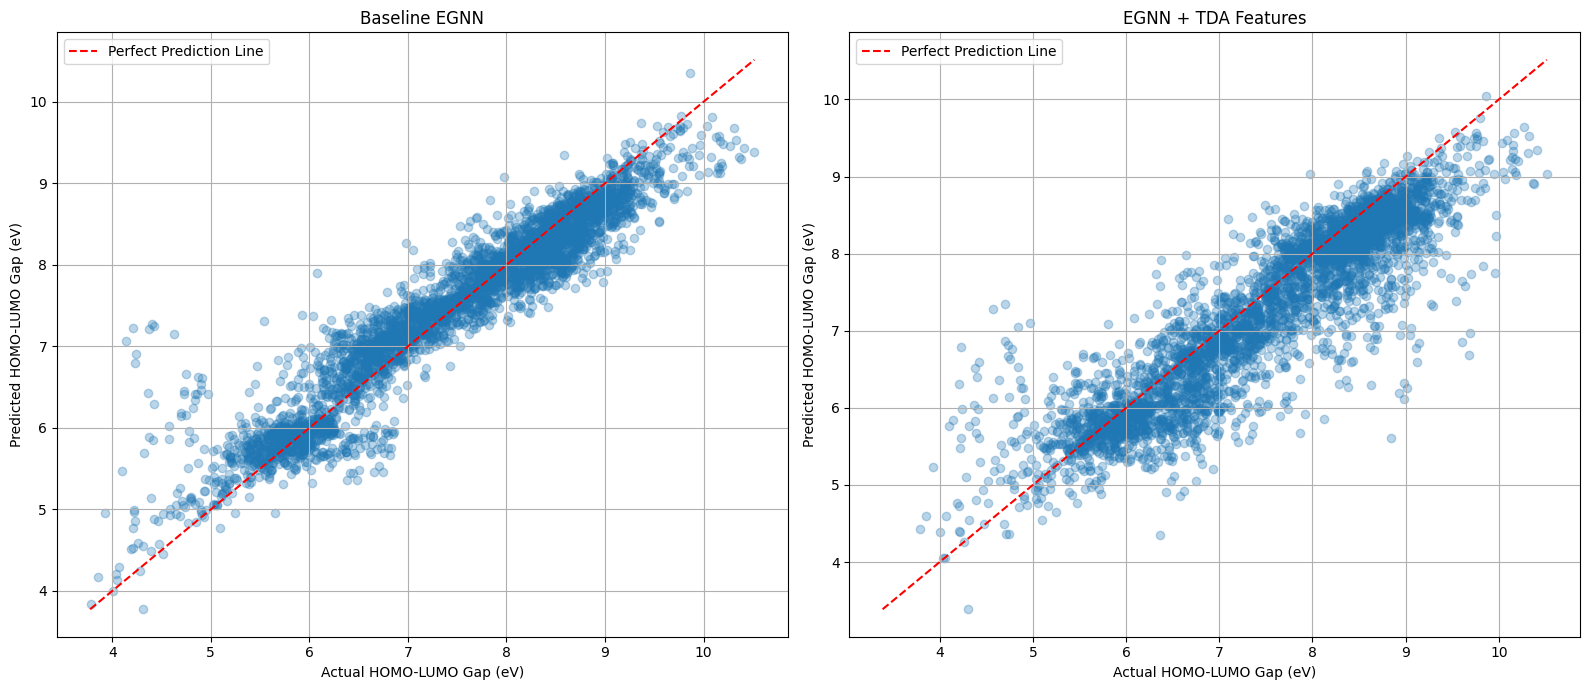

In [32]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

actual_values_baseline = baseline_true_labels.numpy()
predicted_values_baseline = baseline_predictions.numpy()
axes[0].scatter(actual_values_baseline, predicted_values_baseline, alpha=0.3)
axes[0].set_xlabel('Actual HOMO-LUMO Gap (eV)')
axes[0].set_ylabel('Predicted HOMO-LUMO Gap (eV)')
axes[0].set_title('Baseline EGNN')
min_val_baseline = min(actual_values_baseline.min(), predicted_values_baseline.min())
max_val_baseline = max(actual_values_baseline.max(), predicted_values_baseline.max())
axes[0].plot([min_val_baseline, max_val_baseline], [min_val_baseline, max_val_baseline], 'r--', label='Perfect Prediction Line')
axes[0].legend()
axes[0].grid(True)

actual_values_tda = tda_true_labels.numpy()
predicted_values_tda = tda_predictions.numpy()
axes[1].scatter(actual_values_tda, predicted_values_tda, alpha=0.3)
axes[1].set_xlabel('Actual HOMO-LUMO Gap (eV)')
axes[1].set_ylabel('Predicted HOMO-LUMO Gap (eV)')
axes[1].set_title('EGNN + TDA Features')
min_val_tda = min(actual_values_tda.min(), predicted_values_tda.min())
max_val_tda = max(actual_values_tda.max(), predicted_values_tda.max())
axes[1].plot([min_val_tda, max_val_tda], [min_val_tda, max_val_tda], 'r--', label='Perfect Prediction Line')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()